In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the newest dataset
file_path = './data/Milestones_survival_asap_All_60.csv'
data = pd.read_csv(file_path)

# Define columns for survival analysis
time_col = 'implement'          # Time to event
event_col = 'correct'   # Event occurrence (1 for success, 0 for failure)
group_col = 'Group'        # Group identifier

# Ensure valid groups are considered (1 for Treatment, 2 for Control)
valid_groups = [1, 2]
filtered_data = data[data[group_col].isin(valid_groups)]


In [4]:

# Create time intervals for plotting based on the newest dataset
time_intervals = sorted(filtered_data[time_col].unique())

# Separate data by groups
treatment_data = filtered_data[filtered_data[group_col] == 1]
control_data = filtered_data[filtered_data[group_col] == 2]

# Function to calculate cumulative survival rates
def calculate_survival_rates(data, time_col, event_col, time_intervals):
    total = len(data)
    survival_rates = [1.0]  # Initial survival rate
    for t in time_intervals:
        at_risk = data[data[time_col] >= t]
        events = data[(data[time_col] == t) & (data[event_col] == 1)]
        if len(at_risk) > 0:
            survival_rate = 1 - len(events) / len(at_risk)
            survival_rates.append(survival_rates[-1] * survival_rate)
        else:
            survival_rates.append(survival_rates[-1])  # Maintain last survival rate if no data
    return survival_rates[:len(time_intervals)]

# Compute survival rates for each group in the newest dataset
treatment_survival = calculate_survival_rates(treatment_data, time_col, event_col, time_intervals)
control_survival = calculate_survival_rates(control_data, time_col, event_col, time_intervals)


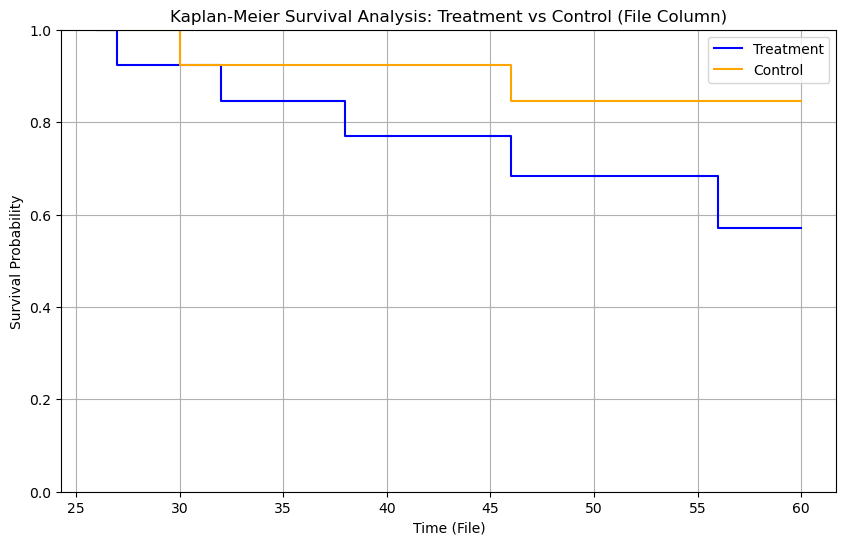

In [5]:

# Plot survival curves for the newest dataset
plt.figure(figsize=(10, 6))
plt.step(time_intervals, treatment_survival, where='post', label='Treatment', color='blue')
plt.step(time_intervals, control_survival, where='post', label='Control', color='orange')

plt.title("Kaplan-Meier Survival Analysis: Treatment vs Control (File Column)")
plt.xlabel("Time (File)")
plt.ylabel("Survival Probability")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


In [6]:

# Function to perform a manual log-rank test
def manual_logrank_test(time_treatment, events_treatment, time_control, events_control):
    event_times = np.unique(np.concatenate((time_treatment, time_control)))
    
    O_treatment = 0
    O_control = 0
    E_treatment = 0
    E_control = 0
    V = 0
    
    for t in event_times:
        n_treatment_at_risk = (time_treatment >= t).sum()
        n_control_at_risk = (time_control >= t).sum()
        n_total_at_risk = n_treatment_at_risk + n_control_at_risk
        
        d_treatment = ((time_treatment == t) & (events_treatment == 1)).sum()
        d_control = ((time_control == t) & (events_control == 1)).sum()
        d_total = d_treatment + d_control
        
        O_treatment += d_treatment
        O_control += d_control
        
        if n_total_at_risk > 0:
            e_treatment = d_total * (n_treatment_at_risk / n_total_at_risk)
            e_control = d_total * (n_control_at_risk / n_total_at_risk)
            
            E_treatment += e_treatment
            E_control += e_control
            
            V += (n_treatment_at_risk * n_control_at_risk * d_total * 
                  (n_total_at_risk - d_total)) / (n_total_at_risk**2 * (n_total_at_risk - 1 + 1e-10))
    
    Z = (O_treatment - E_treatment)**2 / V if V > 0 else 0
    p_value = 1 - pd.Series([Z]).apply(lambda x: 0 if x == 0 else np.exp(-0.5 * x)).iloc[0]
    
    return Z, p_value

# Perform the manual log-rank test
test_statistic, p_value = manual_logrank_test(
    treatment_data[time_col].values,
    treatment_data[event_col].values,
    control_data[time_col].values,
    control_data[event_col].values
)

# Compute -log2(p)
neg_log2_p = -np.log2(p_value) if p_value > 0 else np.inf

# Display results
print(f"Test Statistic: {test_statistic}")
print(f"p-value: {p_value}")
print(f"-log2(p): {neg_log2_p}")


Test Statistic: 1.049122117953101
p-value: 0.4081849207205278
-log2(p): 1.2927052079688264
